This notebook is desined for tabular classification tasks with pandas and scikit-learn.
It is a simple example of how to use pandas and scikit-learn to build a classification model using a tabular dataset. The code includes data preprocessing, model training, and evaluation steps.
The dataset used in this example is the bank marketing dataset from the UCI Machine Learning Repository. The dataset contains information about a bank's marketing campaign and whether or not a customer subscribed to a term deposit.
The goal is to predict whether a customer will subscribe to a term deposit based on their demographic and behavioral features.


In [101]:
# Import necessary libraries
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder,LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [102]:
data=pd.read_csv('/home/tisinr/Dev/models/classifier/dataset/bank.csv',header=0, sep=';')
# Display the first few rows of the dataset
print(data.head())

   age           job  marital  education  ... pdays  previous poutcome   y
0   58    management  married   tertiary  ...    -1         0  unknown  no
1   44    technician   single  secondary  ...    -1         0  unknown  no
2   33  entrepreneur  married  secondary  ...    -1         0  unknown  no
3   47   blue-collar  married    unknown  ...    -1         0  unknown  no
4   33       unknown   single    unknown  ...    -1         0  unknown  no

[5 rows x 17 columns]


In [103]:
def rename_n_change(data):
    # Rename columns for better readability
    data.rename(columns={
        'marital':'marital_status',
        'default':'credit_default',
        'housing':'housing_loan',
        'loan':'personal_loan',
        'y':'response'}, inplace=True)
    #change data types for faster loading
    data['response'] = data['response'].astype('category')
    data['marital_status'] = data['marital_status'].astype('category')
    data['education'] = data['education'].astype('category')
    data['job'] = data['job'].astype('category')
    data['contact'] = data['contact'].astype('category')
    data['month'] = data['month'].astype('category')
    data['day'] = data['day'].astype('category')
    data['credit_default'] = data['credit_default'].astype('category')
    data['housing_loan'] = data['housing_loan'].astype('category')
    data['personal_loan'] = data['personal_loan'].astype('category')
    return data
data=rename_n_change(data)

In [ ]:
data['poutcome'].value_counts(dropna=False)/len(data)*100

In [ ]:
# Drop poutcome with more than 80% unknown values
data.drop('poutcome', axis=1, inplace=True)


In [ ]:
data.isnull().sum()

Determine if data is imbalance

In [ ]:
data['response'].value_counts()/len(data)*100

In [ ]:
print(data.head(10))

Exploratory Data Analysis with Pandas

In [ ]:
plt.figure(figsize=(8,12))
sns.set_style('whitegrid')
sns.pairplot(data,hue='response')
plt.show()

In [ ]:
data.day

In [ ]:
data.info()

In [ ]:
data.describe()

In [ ]:
#Distribution plot of response variable
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.countplot(x='response', data=data)
plt.title('Distribution of Target Variable')
plt.xlabel('response')
plt.ylabel('Count')
plt.show()


In [ ]:
plt.figure(figsize=(8, 6))
data['housing_loan'].value_counts().plot(kind='bar',color=['blue', 'orange'])
plt.title('Distribution of Housing Loan')
plt.xlabel('Housing Loan')
plt.ylabel('Count')
plt.show()

In [ ]:
# Distribution plot of numeric features
plt.figure(figsize=(12, 8))
numeric_ft = data[['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']]
sns.pairplot(numeric_ft)
plt.title('Pairplot of Numeric Features')
plt.show()


In [ ]:
#Correlation matrix for numeric features
plt.figure(figsize=(12, 8))
corr_matrix = numeric_ft.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


Assign features and labels

In [104]:
X=data.drop(columns=['response'])
y=data['response']
print(X.shape)
print(y.shape)

(45211, 16)
(45211,)


Apply Preprocessing to Data

In [105]:
# Create a pipeline for preprocessing
numeric_features = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'marital_status', 'education', 'month', 'housing_loan', 'personal_loan','contact','credit_default']
# Create a column transformer to apply different preprocessing steps to different columns
pre_processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
# Create a pipeline that first applies the preprocessor and then fits a classifier
pre_pipeline = Pipeline(steps=[
    ('preprocessor', pre_processor)
])

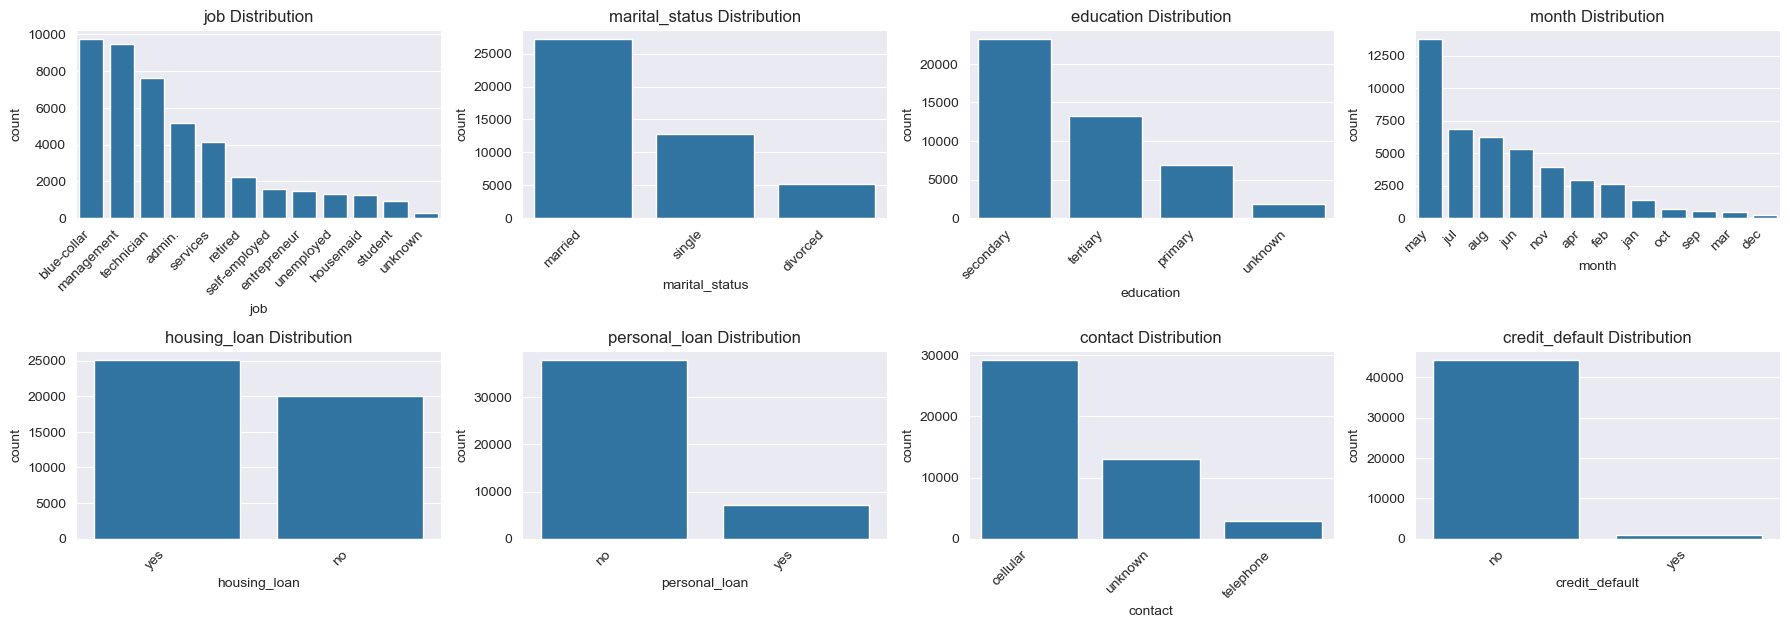

In [106]:
# Create subplots for the categorical variables
plt.figure(figsize=(18, 12))  
for i, variable in enumerate(categorical_features, 1):
    plt.subplot(4, 4, i) 
    sns.countplot(data=data, x=variable, order=data[variable].value_counts().index)
    plt.title(f'{variable} Distribution')
    plt.xticks(rotation=45, ha='right') 
plt.tight_layout() 
plt.show() 

In [107]:
#Split the data into training and testing sets
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=0.8,stratify=y,random_state=78)

In [108]:
# Label encode the target variable
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [109]:
# Fit preprocessing on training data and transform both sets
X_train = pre_pipeline.fit_transform(X_train)
X_test = pre_pipeline.transform(X_test)  # No fitting on test data!

In [110]:
print(X_train.shape)
print(X_test.shape)


(36168, 47)
(9043, 47)


In [111]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

Logistic Regression with Scikit-learn training steps

In [112]:
#Instantiate and train
logreg=LogisticRegression(class_weight= 'balanced')
logreg.fit(X_train,y_train)

LogisticRegression(class_weight='balanced')

In [113]:
logreg.score(X_train,y_train)

0.8364592792059367

In [114]:
logreg.score(X_test,y_test)

0.824062811014044

Logistic Regression
Accuracy:  0.824062811014044
Classification Report: 
               precision    recall  f1-score   support

           0       0.97      0.83      0.89      7985
           1       0.38      0.80      0.51      1058

    accuracy                           0.82      9043
   macro avg       0.67      0.81      0.70      9043
weighted avg       0.90      0.82      0.85      9043

Confusion Matrix: 
 [[6608 1377]
 [ 214  844]]
ROC_AUC_Score:  0.8900373218688632


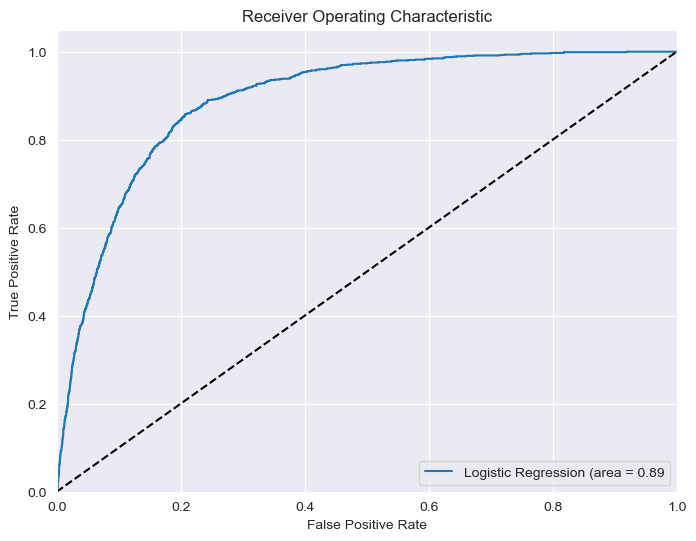

In [115]:
# Predict, Evaluate and plot
y_pred=logreg.predict(X_test)
y_pred_proba=logreg.predict_proba(X_test)[:,1]
print("Logistic Regression")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC_AUC_Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Logistic Regression (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()     

Decision Tree with Scikit-learn training steps

Decision Tree Classifier
Accuracy:  0.8640937741899812
Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      7985
           1       0.43      0.49      0.46      1058

    accuracy                           0.86      9043
   macro avg       0.68      0.70      0.69      9043
weighted avg       0.87      0.86      0.87      9043

Confusion Matrix: 
 [[7297  688]
 [ 541  517]]
ROC AUC Score:  0.7012481460394193


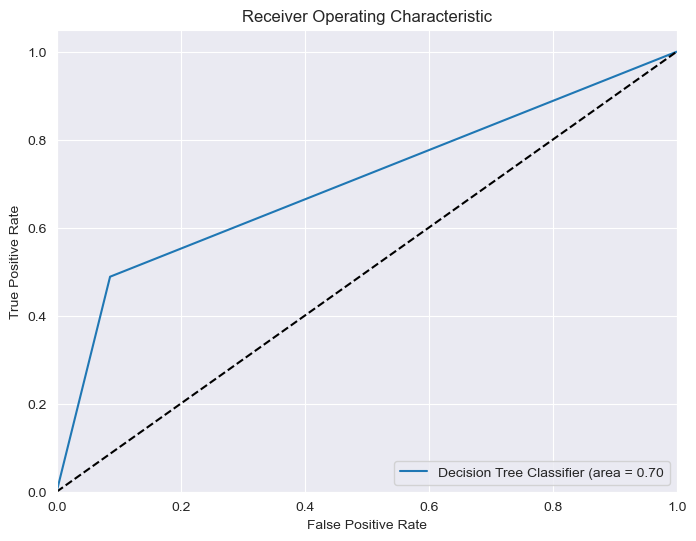

In [116]:
#Decision Tree Classifier
dtree=DecisionTreeClassifier()
dtree.fit(X_train,y_train)
y_pred=dtree.predict(X_test)
y_pred_proba=dtree.predict_proba(X_test)[:,1]
print("Decision Tree Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Decision Tree Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Random Forest with Scikit-learn training steps

Random Forest Classifier
Accuracy:  0.8917394669910428
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      7985
           1       0.54      0.53      0.53      1058

    accuracy                           0.89      9043
   macro avg       0.74      0.73      0.74      9043
weighted avg       0.89      0.89      0.89      9043

Confusion Matrix: 
 [[7508  477]
 [ 502  556]]
ROC AUC Score:  0.9207450051076391


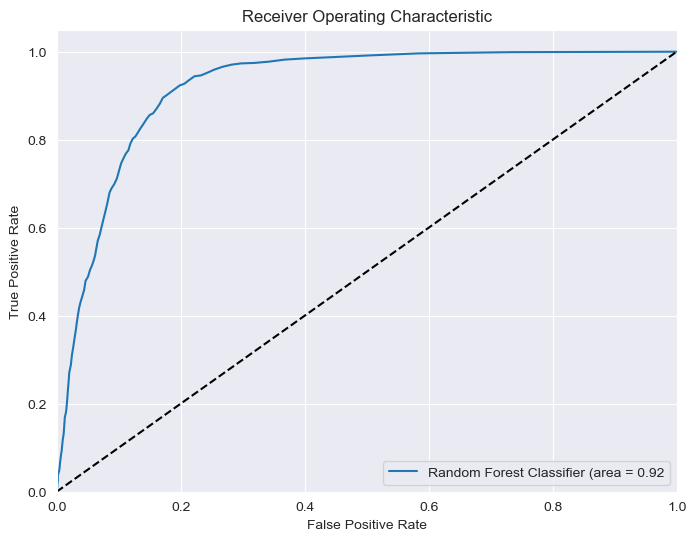

In [117]:
#Random Forest Classifier
rforest=RandomForestClassifier(class_weight= 'balanced',n_estimators=100)
rforest.fit(X_train,y_train)
y_pred=rforest.predict(X_test)
y_pred_proba=rforest.predict_proba(X_test)[:,1]
print("Random Forest Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Random Forest Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Gradient Boosting with Scikit-learn training steps

Gradient Boosting Classifier
Accuracy:  0.8728298131151166
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.89      0.93      7985
           1       0.47      0.74      0.58      1058

    accuracy                           0.87      9043
   macro avg       0.72      0.82      0.75      9043
weighted avg       0.91      0.87      0.88      9043

Confusion Matrix: 
 [[7105  880]
 [ 270  788]]
ROC AUC Score:  0.9092321022522143


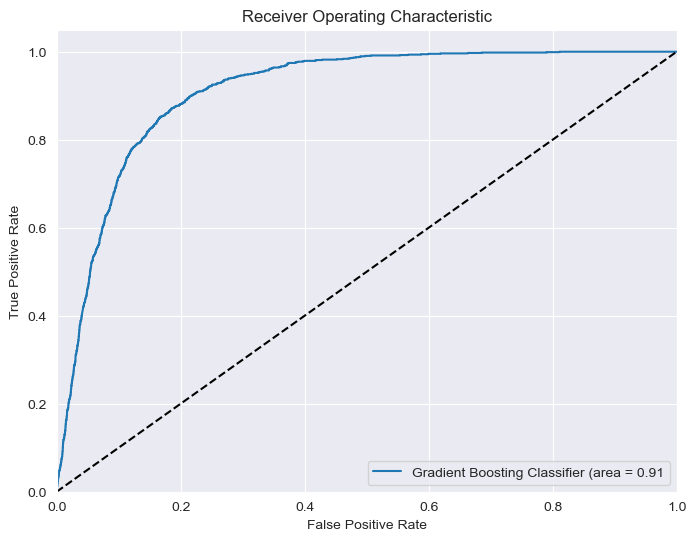

In [118]:
#Gradient Boosting Classifier
gbm=GradientBoostingClassifier()
gbm.fit(X_train,y_train)
y_pred=gbm.predict(X_test)
y_pred_proba=gbm.predict_proba(X_test)[:,1]
print("Gradient Boosting Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gradient Boosting Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

SVC with Scikit-learn training steps

In [ ]:
#Support Vector Classifier
svc=SVC(class_weight= 'balanced',probability=True)
svc.fit(X_train,y_train)
y_pred=svc.predict(X_test)
y_pred_proba=svc.predict_proba(X_test)[:,1]
print("Support Vector Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Support Vector Classifier (area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

GaussianNB with Scikit-learn training steps

Gaussian Naive Bayes
Accuracy:  0.7391352427291827
Classification Report: 
               precision    recall  f1-score   support

           0       0.94      0.75      0.84      7985
           1       0.26      0.66      0.37      1058

    accuracy                           0.74      9043
   macro avg       0.60      0.70      0.60      9043
weighted avg       0.86      0.74      0.78      9043

Confusion Matrix: 
 [[5987 1998]
 [ 361  697]]
ROC AUC Score:  0.75337305415518


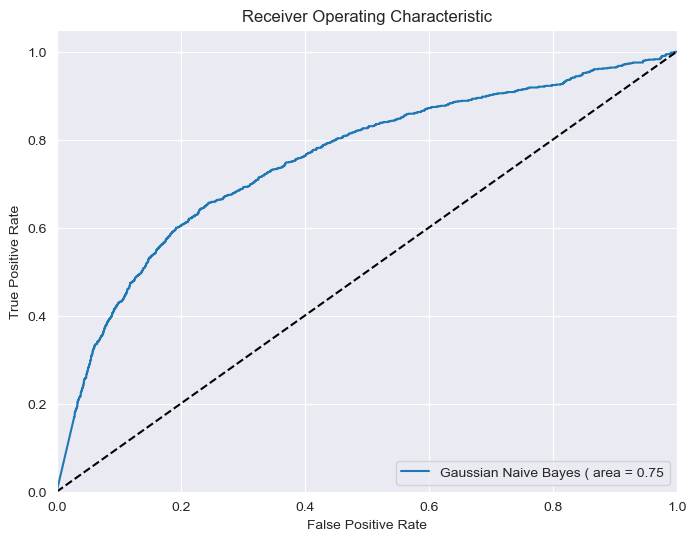

In [119]:
#Gaussian Naive Bayes
gnb=GaussianNB()
gnb.fit(X_train,y_train)
y_pred=gnb.predict(X_test)
y_pred_proba=gnb.predict_proba(X_test)[:,1]
print("Gaussian Naive Bayes")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label= f'Gaussian Naive Bayes ( area = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

KNeighbors with Scikit-learn training steps

K Neighbors Classifier
Accuracy:  0.8376644918721663
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.85      0.90      7985
           1       0.39      0.71      0.51      1058

    accuracy                           0.84      9043
   macro avg       0.68      0.78      0.70      9043
weighted avg       0.89      0.84      0.86      9043

Confusion Matrix: 
 [[6821 1164]
 [ 304  754]]
ROC AUC Score:  0.8453194375560036


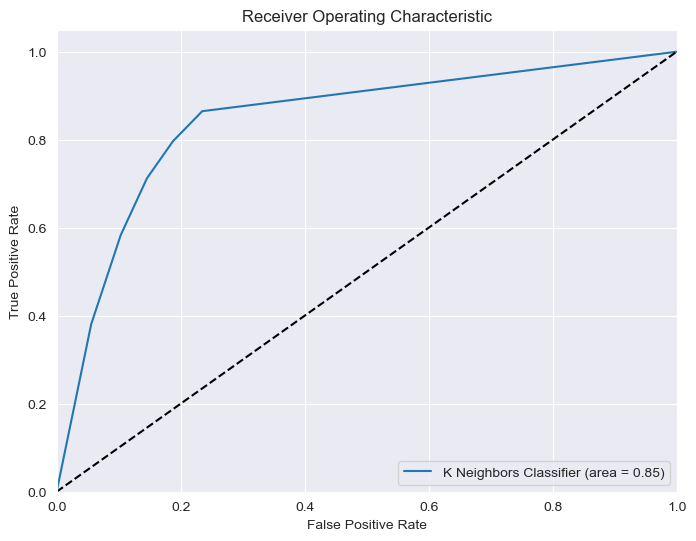

In [120]:
#K Neighbors Classifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
y_pred_proba=knn.predict_proba(X_test)[:,1]
print("K Neighbors Classifier")
print("Accuracy: ",accuracy_score(y_test,y_pred))
print("Classification Report: \n",classification_report(y_test,y_pred))
print("Confusion Matrix: \n",confusion_matrix(y_test,y_pred))
print("ROC AUC Score: ",roc_auc_score(y_test,y_pred_proba))
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='K Neighbors Classifier (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [ ]:
# Create a DataFrame to store the results
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVC', 'Gaussian Naive Bayes', 'K Neighbors'],
    'Accuracy': [accuracy_score(y_test, logreg.predict(X_test)), 
                 accuracy_score(y_test, dtree.predict(X_test)), 
                 accuracy_score(y_test, rforest.predict(X_test)), 
                 accuracy_score(y_test, gbm.predict(X_test)), 
                 accuracy_score(y_test, svc.predict(X_test)), 
                 accuracy_score(y_test, gnb.predict(X_test)), 
                 accuracy_score(y_test, knn.predict(X_test))],
    'ROC_AUC_Score': [roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, dtree.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, rforest.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gbm.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, svc.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, gnb.predict_proba(X_test)[:, 1]), 
                      roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])]
})

In [ ]:
# Sort the results by ROC_AUC_Score in descending order
results = results.sort_values(by='ROC_AUC_Score', ascending = False,ignore_index = True)
# Display the results
print(results)

In [ ]:
# Save the model
joblib.dump(logreg, 'logreg_model.pkl')
joblib.dump(dtree, 'dtree_model.pkl')
joblib.dump(rforest, 'rforest_model.pkl')
joblib.dump(gbm, 'gbm_model.pkl')
joblib.dump(svc, 'svc_model.pkl')
joblib.dump(gnb, 'gnb_model.pkl')
joblib.dump(knn, 'knn_model.pkl')
joblib.dump(pre_pipeline, 'pre_pipeline.pkl')
joblib.dump(label_encoder, 'label_encoder.pkl')

In [ ]:
# Load the model
logreg_ = joblib.load('logreg_model.pkl')
dtree_ = joblib.load('dtree_model.pkl')
rforest_ = joblib.load('rforest_model.pkl')
gbm_ = joblib.load('gbm_model.pkl')
svc_ = joblib.load('svc_model.pkl')
gnb_ = joblib.load('gnb_model.pkl')
knn_ = joblib.load('knn_model.pkl')

In [ ]:
# Make predictions on new data
new_data = pd.DataFrame({
    'age': [30],
    'balance': [1000],
    'day': [15],
    'duration': [200],
    'campaign': [1],
    'pdays': [999],
    'previous': [0],
    'job': ['admin.'],
    'contact': ['cellular'],
    'marital_status': ['single'],
    'education': ['university.degree'],
    'month': ['may'],
    'housing_loan': ['yes'],
    'personal_loan': ['no'],
    'credit_default': ['no']
})

In [ ]:
# Preprocess the new data
new_data = pd.DataFrame(pre_processor.transform(new_data), columns=pre_processor.get_feature_names_out())
# Make predictions
logreg_pred = logreg_.predict(new_data)
dtree_pred = dtree_.predict(new_data)
rforest_pred = rforest_.predict(new_data)
gbm_pred = gbm_.predict(new_data)
svc_pred = svc_.predict(new_data)
gnb_pred = gnb_.predict(new_data)
knn_pred = knn_.predict(new_data)
# Print the predictions
print("Logistic Regression Prediction: ", logreg_pred)
print("Decision Tree Prediction: ", dtree_pred)
print("Random Forest Prediction: ", rforest_pred)
print("Gradient Boosting Prediction: ", gbm_pred)
print("SVC Prediction: ", svc_pred)
print("Gaussian Naive Bayes Prediction: ", gnb_pred)
print("K Neighbors Prediction: ", knn_pred)